In [1]:
from tqdm import tqdm
from jax.example_libraries.optimizers import adam
from jax import value_and_grad
from collections import namedtuple
import os
#os.environ["CUDA_VISIBLE_DEVICES"] ='3'
import numpy as np
import matplotlib.pyplot as plt 
import jax
import jax.numpy as jnp
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second, dGfa, Gf)
from jax import tree
from jax import tree
from jaxpm.pm import pm_forces
from diffrax import ConstantStepSize,  SaveAt, diffeqsolve,StepTo
from jaxpm.plotting import plot_fields_single_projection
from jaxpm.painting import cic_paint , cic_paint_dx
import diffrax
#jax.config.update("jax_enable_x64", True)
import jax
jax.print_environment_info()
from SuperResPM.configure import Configuration
from SuperResPM.diffrax_helper import FPMODE,FPMLeapFrog,symplectic_ode
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('jpeg')
import jax_cosmo as jc
from diffrax import ConstantStepSize
from jaxpm.pm import linear_field, lpt
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader
%matplotlib inline 


jax:    0.5.2
jaxlib: 0.5.1
numpy:  1.26.4
python: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
device info: NVIDIA A100-PCIE-40GB-1, 1 local devices"
process_count: 1
platform: uname_result(system='Linux', node='midway3-0294.rcc.local', release='4.18.0-305.3.1.el8.x86_64', version='#1 SMP Tue Jun 1 16:14:33 UTC 2021', machine='x86_64')


$ nvidia-smi
Fri Apr 18 18:41:29 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=======================================

/project/chto/chto/anaconda/newenv4/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
jax.config.update("jax_enable_x64", True)

In [3]:

def full_field_model_pm_test(
    cube_size,
    cubegrid_size,
    a_init,
    a_center,
    adjoint
):
    @jax.jit
    def forward_model(cosmoin, lin_field):
        def paint_density(t, y, args):
            # Load positions and apply boundary conditions
            pos = y[0]
            x = pos[..., 1]
            y = pos[..., 2]
            z = pos[..., 0]

            # Paint all the particles that fall into slice
            ss=args[1]
            density = cic_paint(jnp.zeros(ss),jnp.c_[x, y, z])

            return density
            
        particles = jnp.stack(
            jnp.meshgrid(
                *[jnp.arange(s) for s in [cubegrid_size, cubegrid_size, cubegrid_size]]
            ),
            axis=-1)
        conf = Configuration(mesh_shape=[cubegrid_size, cubegrid_size, cubegrid_size],
                     snapshots= [1],
                     BoxSize=cube_size, 
                     initial_t0=a_init,
                     final_time = 1.0,
                     density_plane_npix = 10,
                     dt0=0.01)

        
        eps, p, f = lpt(cosmoin, lin_field, particles, a=conf.initial_t0)
        
        term = tree.map(
            FPMODE,
            symplectic_ode(conf.mesh_shape, paint_absolute_pos=True)
        )
        initforce = pm_forces(
            particles + eps,
            mesh_shape=conf.mesh_shape,
            paint_absolute_pos=True,
        )* 1.5* cosmoin.Omega_m  

        solver = FPMLeapFrog(initial_t0=conf.initial_t0, final_t1=conf.final_time)
        saveat = SaveAt(t1=True)
        stepsize_controller = ConstantStepSize()
        solution = diffeqsolve(
            term,
            solver,
            t0=conf.initial_t0,
            t1=conf.final_time,
            dt0=conf.dt0,
            y0=jnp.stack([particles + eps, p, initforce], axis=0),
            args=[cosmoin, None, conf.initial_t0, conf, 0, 0],\
            saveat=saveat,
            adjoint=adjoint,
            stepsize_controller=stepsize_controller,
        )
        
        args = [None, [cubegrid_size, cubegrid_size, cubegrid_size]]
        density = paint_density(0, solution.ys[-1], args)
        return density
    return forward_model
#####################################################################################################################


In [4]:

#if __name__ == "__main__":
key_number = 1
# Set output directory
dir_out = "./"
#Path(dir_out).mkdir(parents=True, exist_ok=True)
# Sim configuration
cube_size = 128.0  # Mpc/h
cubegrid_size = 32  # npix
a_init = 0.05
# Initialize the density model
dens_model_Recursive= full_field_model_pm_test(
    cube_size=cube_size,
    cubegrid_size=cubegrid_size,
    a_init = a_init,
    a_center=[1],#np.linspace(a_init,1,41)[::-1], 
    adjoint=diffrax.RecursiveCheckpointAdjoint(20)
)
dens_model_Reversible= full_field_model_pm_test(
    cube_size=cube_size,
    cubegrid_size=cubegrid_size,
    a_init = a_init,
    a_center=[1],#np.linspace(a_init,1,41)[::-1], 
    adjoint=diffrax.ReversibleAdjoint()#diffrax.RecursiveCheckpointAdjoint()#
)


In [18]:
def buildmodel(dens_model):
    @jax.jit
    def model(param):
        Omega_c, sigma8= param
        model_cosmo = jc.Cosmology(
            Omega_c=Omega_c,
            sigma8=sigma8,
            Omega_b=0.0492,
            Omega_k=0.0,
            h=0.67,
            n_s=0.96,
            w0=-1,
            wa=0.0,
        )
        Workspace = namedtuple('_workspace', ['background_radial_comoving_distance', 'background_growth_factor'])
        model_cosmo._workspace =Workspace(None, None)
        ain=np.atleast_1d(1)
        _ =  growth_rate_second(model_cosmo,ain)
        _ = growth_rate(model_cosmo, ain)
        _ = growth_factor(model_cosmo, ain)
        jc.background.radial_comoving_distance(model_cosmo, ain)
        k = jnp.logspace(-4, 1, 128)
        pk = jc.power.linear_matter_power(model_cosmo, k)
        pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)
        lin_field = linear_field(
            [cubegrid_size, cubegrid_size, cubegrid_size],
            [cube_size, cube_size, cube_size],
            pk_fn, jax.random.PRNGKey(0))
        dens = dens_model(model_cosmo, lin_field)
        return dens
    return model    


In [19]:
densobs = buildmodel(dens_model=dens_model_Recursive)(jnp.array([0.3,0.8]))


In [48]:
model_Reversible = buildmodel(dens_model=dens_model_Reversible)
model_Recursive = buildmodel(dens_model=dens_model_Recursive)

In [49]:
def lnlikelihood(param, model):
    din = model(param)
    return jnp.sum(-0.5*(densobs-din)**2)

In [50]:
dL = jax.value_and_grad(lnlikelihood)

In [44]:
cosmology_omegam = np.random.normal(size=100)*0.02+0.3

In [45]:
cosmology_sigma8 = np.random.normal(size=100)*0.1+0.8

In [58]:
%prun dL(jnp.array([omegam, sigma8]), model)[1]

         310109 function calls (309413 primitive calls) in 1.323 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.797    0.797    0.802    0.802 pxla.py:2649(_get_layouts_from_executable)
        8    0.233    0.029    1.237    0.155 pjit.py:1695(_pjit_call_impl)
        1    0.176    0.176    0.176    0.176 pxla.py:1277(__call__)
      6/1    0.006    0.001    1.321    1.321 traceback_util.py:176(reraise_with_filtered_traceback)
    67396    0.006    0.000    0.006    0.000 {built-in method builtins.isinstance}
     2191    0.004    0.000    0.004    0.000 {jaxlib.utils.safe_zip}
    241/4    0.003    0.000    0.016    0.004 partial_eval.py:1344(_jaxpr_forwarding)
     2031    0.003    0.000    0.004    0.000 sharding_impls.py:666(get_replicated)
        1    0.003    0.003    0.015    0.015 util.py:222(toposort)
        1    0.003    0.003    0.026    0.026 partial_eval.py:754(tracers_to_jaxpr)
     6114    

In [ ]:
derivative=[]
for omegam, sigma8 in tqdm(zip(cosmology_omegam, cosmology_sigma8)):
    d1 = dL(jnp.array([omegam, sigma8]), model_Reversible)[1]
    d2 = dL(jnp.array([omegam, sigma8]), model_Recursive)[1]
    derivative.append([d1,d2])
    print(d1,d2)

1it [00:02,  2.41s/it]

[ 24686.1405158  -60941.33766088] [ 24686.14051578 -60941.33766088]


2it [00:04,  2.36s/it]

[-29868.63212627  98381.36408115] [-29868.63212623  98381.36408115]


3it [00:07,  2.34s/it]

[  53210.2275851  -144244.69526582] [  53210.22758505 -144244.69526581]


4it [00:09,  2.34s/it]

[-63092.52090346 234577.05153544] [-63092.52090339 234577.05153544]


5it [00:11,  2.33s/it]

[  98234.09088212 -196127.14783364] [  98234.09088203 -196127.14783364]


6it [00:14,  2.33s/it]

[-56420.38455385 179238.58949039] [-56420.3845538  179238.58949038]


7it [00:16,  2.33s/it]

[-68653.03775826 261376.2603356 ] [-68653.03775818 261376.2603356 ]


8it [00:18,  2.32s/it]

[  41976.61913872 -148272.04370967] [  41976.61913866 -148272.04370967]


9it [00:20,  2.32s/it]

[  51253.00543919 -110199.40181756] [  51253.00543914 -110199.40181756]


10it [00:23,  2.34s/it]

[-29964.71964342  75671.68290032] [-29964.7196434   75671.68290032]


11it [00:26,  2.43s/it]

[  46162.07833703 -127833.20858325] [  46162.07833698 -127833.20858325]


12it [00:28,  2.43s/it]

[-37724.55300665 139095.63918748] [-37724.5530066  139095.63918748]


13it [00:30,  2.44s/it]

[-22258.78154748  41697.58030399] [-22258.78154747  41697.58030399]


14it [00:33,  2.47s/it]

[-18939.86567329  42813.68363395] [-18939.86567328  42813.68363395]


15it [00:35,  2.35s/it]

[-6189.69285678 31920.7296083 ] [-6189.69285677 31920.7296083 ]


16it [00:37,  2.26s/it]

[-18642.94198974  39369.09774421] [-18642.94198972  39369.09774421]


17it [00:39,  2.21s/it]

[-47499.49800645 162139.94238137] [-47499.49800639 162139.94238137]


18it [00:42,  2.31s/it]

[ 21798.84960367 -88553.94112931] [ 21798.84960363 -88553.94112931]


19it [00:44,  2.36s/it]

[ 12222.14679504 -45147.64389324] [ 12222.14679503 -45147.64389323]


20it [00:47,  2.44s/it]

[-7888.81499215 33567.76004748] [-7888.81499214 33567.76004748]


21it [00:49,  2.47s/it]

[ 28340.86675608 -96262.92404018] [ 28340.86675604 -96262.92404018]


22it [00:52,  2.49s/it]

[-11439.17824494  38626.64611562] [-11439.17824493  38626.64611562]


23it [00:54,  2.50s/it]

[ 18661.00303559 -53228.34686561] [ 18661.00303557 -53228.34686561]


24it [00:57,  2.57s/it]

[-56711.2647539 217900.5825729] [-56711.26475383 217900.5825729 ]


25it [01:00,  2.70s/it]

[  5044.81937748 -15971.66648978] [  5044.81937748 -15971.66648978]


26it [01:03,  2.72s/it]

[-90832.65394141 355887.05850002] [-90832.6539413  355887.05850002]


27it [01:06,  2.75s/it]

[  72635.49864355 -154373.37660925] [  72635.49864348 -154373.37660924]


28it [01:08,  2.73s/it]

[  1611.80652073 -10499.29878654] [  1611.80652073 -10499.29878654]


29it [01:11,  2.71s/it]

[  6236.9296544  -19489.84044313] [  6236.92965439 -19489.84044313]


30it [01:14,  2.71s/it]

[  5854.45205615 -18046.44480799] [  5854.45205614 -18046.44480799]


31it [01:17,  2.73s/it]

[  68041.95086058 -153685.42975848] [  68041.95086052 -153685.42975848]


32it [01:19,  2.68s/it]

[  64112.05082882 -138786.45734203] [  64112.05082876 -138786.45734203]


33it [01:22,  2.64s/it]

[ 4676.00064914 17329.53238141] [ 4676.00064915 17329.53238141]


34it [01:24,  2.59s/it]

[-41858.83787715 156078.18160311] [-41858.8378771  156078.18160311]


35it [01:27,  2.59s/it]

[-133723.79309339  563832.8547049 ] [-133723.79309323  563832.85470489]


In [52]:
derivative = np.array(derivative)

In [53]:
derivative.shape

(100, 2, 2)

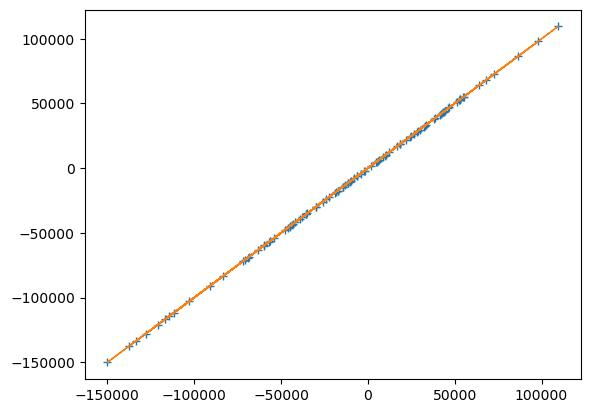

In [57]:
plt.plot(derivative[:,0,0],derivative[:,1,0], "+")
plt.plot(derivative[:,0,0],derivative[:,0,0], lw=1)




In [54]:
jax.value_and_grad(lnlikelihood)(jnp.array([0.2,0.8]), dens_model=dens_model_Recursive)

(Array(-12840.21854635, dtype=float64),
 Array([315351.19248804, 493830.4151344 ], dtype=float64))

In [74]:
cubegrid_size

(32,)

In [9]:

#adjoint = diffrax.RecursiveCheckpointAdjoint()#
def paint_density(t, y, args2):
        # Load positions and apply boundary conditions
        pos = y[0]
        x = pos[..., 1]
        y = pos[..., 2]
        z = pos[..., 0]

        # Paint all the particles that fall into slice
        ss=args2[1]
        density = cic_paint(jnp.zeros(ss),jnp.c_[x, y, z])

        return density
    
#def forward_model(cosmoin, lin_field, conf):
#
#    eps, p, f = lpt(cosmoin, lin_field,  a=conf.initial_t0)
#    
#    ode_fn = tree.map(
#        FPMODE,
#        symplectic_ode(conf.mesh_shape, paint_absolute_pos=False)
#    )
#    solver = FPMLeapFrog(initial_t0=conf.initial_t0, final_t1=conf.final_time)
#    saveat = SaveAt(t1=True)
#    stepsize_controller = ConstantStepSize()
#    
#    initforce = pm_forces(
#        eps,
#        mesh_shape=conf.mesh_shape,
#        paint_absolute_pos=False,
#    )* 1.5* cosmoin.Omega_m  
#
#    solution = diffeqsolve(
#        ode_fn,
#        solver,
#        t0=conf.initial_t0,
#        t1=conf.final_time,
#        dt0=conf.dt0,
#        y0=jnp.stack([eps, p, initforce], axis=0),
#        args=[cosmoin, None, conf.initial_t0, conf, 0, 0],\
#        saveat=saveat,
#        adjoint=adjoint,
#        stepsize_controller=stepsize_controller,
#    )
#    a, b, c = jnp.meshgrid(jnp.arange(conf.mesh_shape[0]),
#                           jnp.arange(conf.mesh_shape[1]),
#                           jnp.arange(conf.mesh_shape[2]),
#                           indexing='ij')
#    pmid = jnp.stack([a , b , c], axis=-1)
#    args = [None, [cubegrid_size, cubegrid_size, cubegrid_size]]
#    density = paint_density(0,  pmid+solution.ys[-1], args)
#    return density

In [15]:

def forward_model(cosmo, lin_field, conf):
    mesh_shape = conf.mesh_shape
    initial_t0 = conf.initial_t0
    final_time = conf.final_time
    snapshots = conf.snapshots
    nmesh = conf.mesh_shape[0]
    dt0 = conf.dt0
    
    dx, p, f = lpt(cosmo, lin_field, a=conf.initial_t0)
    
    ode_fn = tree.map(
        FPMODE,
        symplectic_ode(conf.mesh_shape, paint_absolute_pos=False)
    )
    solver = FPMLeapFrog(initial_t0=conf.initial_t0, final_t1=conf.final_time)
    stepsize_controller = ConstantStepSize()

    initforce = pm_forces(
        dx,
        mesh_shape=mesh_shape,
        paint_absolute_pos=False,
    )* 1.5* cosmo.Omega_m        
    y0=jnp.stack([dx, p,initforce], axis=0)
    
    res = diffeqsolve(ode_fn,solver,\
                  t0=initial_t0,\
                  t1=final_time,\
                  dt0=dt0,\
                  y0=y0,
                  args=[cosmo, None, initial_t0, conf, 0, 0],\
                  saveat=SaveAt(t1=True),
                  stepsize_controller=stepsize_controller, adjoint=adjoint)
    
    a, b, c = jnp.meshgrid(jnp.arange(conf.mesh_shape[0]),
                           jnp.arange(conf.mesh_shape[1]),
                           jnp.arange(conf.mesh_shape[2]),
                           indexing='ij')
    pmid = jnp.stack([a , b , c], axis=-1)
    density = paint_density(res.ts[-1],(pmid+res.ys[-1]), [None, conf.mesh_shape] )
    return density

In [20]:
#@jax.jit
def model2(param):
    Omega_c, sigma8= param
    model_cosmo = jc.Cosmology(
        Omega_c=Omega_c,
        sigma8=sigma8,
        Omega_b=0.0492,
        Omega_k=0.0,
        h=0.67,
        n_s=0.96,
        w0=-1,
        wa=0.0,
    )
    cube_size = 256.0  # Mpc/h
    cubegrid_size = 32  # npix
    a_init = 0.05
    Workspace = namedtuple('_workspace', ['background_radial_comoving_distance', 'background_growth_factor'])
    model_cosmo._workspace =Workspace(None, None)
    ain=np.atleast_1d(1)
    _ =  growth_rate_second(model_cosmo,ain)
    _ = growth_rate(model_cosmo, ain)
    _ = growth_factor(model_cosmo, ain)
    jc.background.radial_comoving_distance(model_cosmo, ain)
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(model_cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    conf = Configuration(mesh_shape=[cubegrid_size, cubegrid_size, cubegrid_size],
            snapshots= [1],
            BoxSize=[cube_size,cube_size, cube_size], 
            initial_t0=a_init,
            final_time = 1.0,
            density_plane_npix = 10,
            dt0=0.01)
    lin_field = linear_field(
        conf.mesh_shape,
        conf.BoxSize,
        pk_fn, jax.random.PRNGKey(0))

    dens = forward_model(model_cosmo, lin_field, conf)
    return dens
    


In [21]:
def lnlikelihood(param):
    din = model2(param)
    return jnp.sum(-0.5*(densobs-din)**2)

In [22]:
adjoint=diffrax.ReversibleAdjoint()

jax.value_and_grad(lnlikelihood)(jnp.array([0.2,0.8]))

(Array(-673767.11556316, dtype=float64),
 Array([-2152545.66228224,  1173596.57404377], dtype=float64))

In [24]:
adjoint=diffrax.RecursiveCheckpointAdjoint(20)
jax.value_and_grad(lnlikelihood)(jnp.array([0.2,0.8]))

(Array(-673767.11556316, dtype=float64),
 Array([-1231946.67694215,  1172649.02512137], dtype=float64))